In [17]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(400_000_000_000)

from calitp.tables import tbl
from calitp import query_sql
import calitp.magics
import branca

import shared_utils
import utils

from siuba import *
import pandas as pd
import geopandas as gpd
import shapely

import datetime as dt

import rt_analysis as rt
import importlib

from tqdm import tqdm_notebook
from tqdm.notebook import trange, tqdm

In [18]:
analysis_date = dt.date(2022, 2, 8)

In [19]:
samtrans_itp_id = 290

In [20]:
importlib.reload(utils)
importlib.reload(rt)

<module 'rt_analysis' from '/home/jovyan/data-analyses/rt_delay/rt_analysis.py'>

In [21]:
pbar = tqdm()

0it [00:00, ?it/s]

In [22]:
sam = rt.OperatorDayAnalysis(samtrans_itp_id, analysis_date, pbar)

found parquet
found parquet
found parquet
found parquet
found_parquet
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle positions gdf must not be empty
vehicle po

In [26]:
(sam.stop_delay_view
 >> group_by(_.stop_id, _.stop_name)
 >> summarize(mean_delay = _.delay.mean(), max_delay = _.delay.max())
 >> arrange(-_.mean_delay)) >> head(10)

,stop_id,stop_name,mean_delay,max_delay
1298,343118,Alameda de las Pulgas & Alma St,0 days 00:21:15.454282,0 days 00:28:24.245235
1574,346126,Terminal Ave & Almanor Ave,0 days 00:20:07.792832,0 days 00:20:07.792832
765,334620,South SF BART-Bay 5 Westside Busway,0 days 00:19:56.999178800,0 days 00:31:08.739457
1625,346596,Hamilton Ave & Henderson Ave,0 days 00:19:25.675944,0 days 00:19:25.675944
1626,346597,Hamilton Ave & Hollyburne Ave,0 days 00:18:59.449394,0 days 00:18:59.449394
1623,346594,Kavanaugh Dr & Kirkwood Ct,0 days 00:17:28.461803,0 days 00:17:28.461803
1811,363044,Notre Dame Ave & Illinois St,0 days 00:16:31.244881,0 days 00:16:31.244881
1622,346593,Kavanaugh Dr & Farrington Way,0 days 00:16:19.299827,0 days 00:16:19.299827
291,331100,SF Transit Center - BART shuttle connection,0 days 00:16:16.500606,0 days 00:16:16.500606
356,332046,Pope St & Bellevue Ave,0 days 00:16:03.956056,0 days 00:16:03.956056


In [27]:
sam.set_filter(start_time='15:00', end_time='19:00')

{'start_time': datetime.time(15, 0), 'end_time': datetime.time(19, 0), 'route_ids': None, 'direction_id': None, 'direction': None}


In [28]:
m = sam.segment_speed_map()

view filter: {'start_time': datetime.time(15, 0), 'end_time': datetime.time(19, 0), 'route_ids': None, 'direction_id': None, 'direction': None}
2960292_1_ empty!
SamTrans80:2960292_0_ empty!
SamTrans80:2810273_0_ empty!
2810273_1_ empty!
ECR1063_0_ empty!
SamTrans80:ECR1063_0_ empty!
2860095_1_ empty!
SamTrans80:2860095_0_ empty!
540084_0_ empty!
SamTrans80:170516_1_ empty!
SamTrans80:180039_0_ empty!
170515_1_ empty!
180040_1_ empty!
SamTrans80:1100237_0_ empty!
speed above 80 for shape SamTrans80:1100237, dropping
SamTrans80:1100256_0_ empty!
negative speed for shape 2960306, dropping
negative speed for shape 2960306, dropping
SamTrans80:2810269_1_ empty!
2810269_0_ empty!
SamTrans80:840049_1_ empty!
SamTrans80:830110_0_ empty!
SamTrans80:820056_1_ empty!
350056_0_ empty!
1220565_1_ empty!
SamTrans80:1220565_1_ empty!
280062_1_ empty!
350093_0_ empty!
2600356_1_ empty!
SamTrans80:2600358_1_ empty!
2600357_1_ empty!
SamTrans80:2600357_1_ empty!
ECR1072_1_ empty!
SamTrans80:ECR1072_1_ 

/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract


speed above 80 for shape 3980272, dropping
negative speed for shape 3980272, dropping
3980272_1_ empty!
SamTrans80:3980272_0_ empty!
speed above 80 for shape SamTrans80:3980272, dropping
negative speed for shape SamTrans80:3980272, dropping
SamTrans80:140106_1_ empty!
speed above 80 for shape 1300317, dropping
1300317_1_ empty!
SamTrans80:1300317_1_ empty!
SamTrans80:1210346_1_ empty!
1210331_0_ empty!
2950425_1_ empty!
SamTrans80:2950427_0_ empty!
negative speed for shape SamTrans80:2950427, dropping
negative speed for shape SamTrans80:610093, dropping
SamTrans80:610093_1_ empty!
610093_0_ empty!
negative speed for shape 610093, dropping
negative speed for shape SamTrans80:850086, dropping
SamTrans80:850086_1_ empty!
720063_1_ empty!
2500415_1_ empty!
SamTrans80:1120161_1_ empty!
1120161_1_ empty!
1120180_1_ empty!
590072_1_ empty!
SamTrans80:1210348_0_ empty!
1210348_1_ empty!
negative speed for shape SamTrans80:810070, dropping
SamTrans80:810070_1_ empty!
SamTrans80:810066_1_ empty!

TopologyException: assigned depths do not match at -217628.67881293956 -35629.731197568181
TopologyException: assigned depths do not match at -206250.92608763179 -51291.043813443037
TopologyException: assigned depths do not match at -217628.67881293956 -35629.731197568181
TopologyException: assigned depths do not match at -217628.67881293956 -35629.731197568181
TopologyException: assigned depths do not match at -206250.92608763179 -51291.043813443037
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:634: ShapelyDeprecationWarning: GeometryTypeError will derive from ShapelyError and not TypeError or ValueError in Shapely 2.0.
/home/jovyan/data-analyses/rt_delay/rt_analysis.py:580: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [30]:
# m

In [31]:
sam.vehicle_positions >> count(_.trip_id) >> arrange(_.n)

,trip_id,n
1402,3971004,1
1403,3971005,1
1404,3971006,1
1393,11463589-137-Blocks-Weekday-14,6
1398,11463618-137-Blocks-Weekday-14,11
...,...,...
860,11403512-137-Blocks-Weekday-14,519
1046,11426576-137-Blocks-Weekday-14,526
857,11403509-137-Blocks-Weekday-14,531
1073,11426605-137-Blocks-Weekday-51,576


In [32]:
sam.pct_trips_valid_rt

0.5894955079474775

In [33]:
# sam.position_interpolators['11401903-137-Blocks-Weekday-14']['rt'].detailed_speed_map()

In [34]:
# sam.position_interpolators['11401833-137-Blocks-Weekday-14']['rt'].detailed_speed_map()

### info sandbox


In [35]:
# ac = rt.OperatorDayAnalysis(4, analysis_date, pbar)

In [36]:
# ac.pct_trips_valid_rt

In [37]:
def categorize_cleaning(rt_operator_day, interpolator_key):
    rt_interpolator = rt_operator_day.position_interpolators[interpolator_key]['rt']
    raw = rt_interpolator.position_gdf.shape[0]
    same_loc_dropped = (rt_interpolator.position_gdf >> distinct(_.shape_meters)).shape[0]
    cleaned = rt_interpolator.cleaned_positions.shape[0]
    return (interpolator_key, cleaned / raw, cleaned / same_loc_dropped)

In [38]:
ex = sam.position_interpolators['11454049-137-Blocks-Weekday-14']['rt']

In [39]:
distinct_positions = ex.position_gdf >> distinct(_.shape_meters, _keep_all=True)

In [40]:
import folium

In [41]:
marker = folium.CircleMarker(radius = 3, # Radius in metres
                       weight = 0, #outline weight
                       fill_color = '#000000', 
                       fill_opacity = 1)

In [42]:
def layer_points(rt_interpolator):
    initial_bk_noise = (ex.position_gdf
                        >> filter(_.meters_from_last < 0)
                        >> select(_.geometry, _.shape_meters, _.progressed,
                                  _.secs_from_last, _.meters_from_last)
                       )
    initial_deduped = (ex.position_gdf
                       >> distinct(_.shape_meters, _keep_all=True)
                       >> select(_.geometry, _.shape_meters, _.progressed,
                                 _.secs_from_last, _.meters_from_last)
                      )
    cleaned = ex.cleaned_positions >> select(_.geometry, _.shape_meters, _.progressed,
                                             _.secs_from_last, _.meters_from_last)
    popup_dict = {'shape_meters': 'shape_meters', 'progressed': 'progressed', 'secs_from_last': 'secs_from_last',
                 'meters_from_last': 'meters_from_last'}
    layers_dict = {'initial backwards noise': {'df': initial_bk_noise,
                                              'plot_col': 'shape_meters',
                                              'popup_dict': popup_dict,
                                              'tooltip_dict': popup_dict,
                                              'colorscale': branca.colormap.step.Blues_03},
                   'initial position deduplicated': {'df': initial_deduped,
                                              'plot_col': 'shape_meters',
                                              'popup_dict': popup_dict,
                                              'tooltip_dict': popup_dict,
                                              'colorscale': branca.colormap.step.Greens_03},
                   'cleaned': {'df': cleaned,
                                              'plot_col': 'shape_meters',
                                              'popup_dict': popup_dict,
                                              'tooltip_dict': popup_dict,
                                              'colorscale': branca.colormap.step.Reds_03,
                                              'marker':  marker},
                  }
    return shared_utils.map_utils.make_folium_multiple_layers_map(layers_dict, 900, 500, marker=marker)

In [43]:
# layer_points(ex)

### Complex Shape Geometries

In [44]:
ex.shape.geom_type

'LineString'

In [45]:
geo = ex.shape

In [46]:
geo.is_simple

False

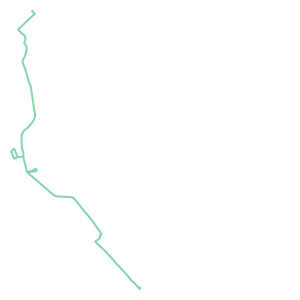

In [49]:
geo

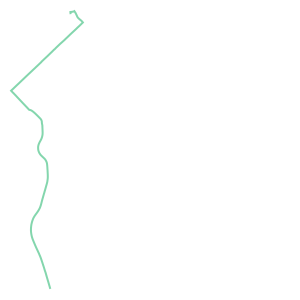

In [53]:
shapely.ops.substring(geo, 0, 10000)

In [ ]:
## self-intersecting, but still handled correctly?
# sam.position_interpolators['11403225-137-Blocks-Weekday-14']['rt'].detailed_speed_map()

In [71]:
g2 = geo.intersection(geo)

In [79]:
[geom.length for geom in g2.geoms]

[23.942378941278793,
 38.998506498757024,
 6.212549190083696,
 7.345178681700836,
 39.62769321925857,
 16.19707205692327,
 28.88008591172699,
 5.5853458219838465,
 8.954084000462494,
 8.22481227452434,
 6.926540776282148,
 41.131020290960734,
 16.68037742265697,
 4.886493349425338,
 11.212795283523558,
 16.491231965877994,
 44.6227922734361,
 27.436933215203638,
 12.043748364927916,
 14.452259106124119,
 14.146004038709298,
 11.197738403589062,
 19.275623749007888,
 18.740897949555166,
 26.08183533263009,
 9.172880904446044,
 45.86446226738955,
 6.552536338396455,
 18.024738481207763,
 18.99909631039477,
 37.92153820622234,
 71.41747512552422,
 80.09812963464181,
 28.892770443758558,
 21.545061269469,
 5.409098619494203,
 80.27599349540696,
 79.92058803557671,
 27.326901890773136,
 29.87638049240705,
 83.52798334926247,
 107.67705862924342,
 86.53001557639068,
 31.307483467387762,
 30.270846950044522,
 29.16104205458352,
 50.80921544542175,
 49.16015609259393,
 19.494913858781143,
 62.

In [90]:
numpy.arange(0, 1, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [92]:
import numpy as np

In [102]:
def show_simple_complex(linestring):
    full_len = linestring.length
    step = 0.05
    for split in np.arange(0, 1, step):
        if split > 1:
            split = 1
        split_st = full_len * split
        split_end = full_len * (split+step)
        # pre_split = shapely.ops.substring(geo, 0, split_st)
        split = shapely.ops.substring(geo, split_st, split_end)
        print(f'{split_st}, {split_end}, {split.is_simple}')

In [104]:
show_simple_complex(geo)

0.0, 2666.694751656083, True
2666.694751656083, 5333.389503312166, True
5333.389503312166, 8000.08425496825, True
8000.08425496825, 10666.779006624332, True
10666.779006624332, 13333.473758280415, True
13333.473758280415, 16000.168509936499, True
16000.1685099365, 18666.86326159258, True
18666.86326159258, 21333.558013248665, True
21333.558013248665, 24000.252764904748, False
24000.252764904748, 26666.94751656083, True
26666.94751656083, 29333.642268216918, True
29333.642268216918, 32000.337019873, True
32000.337019873, 34667.03177152909, True
34667.03177152908, 37333.72652318516, True
37333.72652318516, 40000.421274841254, True
40000.42127484125, 42667.11602649733, True
42667.11602649733, 45333.81077815342, True
45333.81077815342, 48000.5055298095, True
48000.505529809496, 50667.20028146558, True
50667.20028146558, 53333.89503312166, True


In [87]:
import numpy
from shapely.geometry import LineString, Point

complex_line = geo

# initial, non-result
intersection = None

# fraction of total distance at which we'll split the line
for split in numpy.arange(0, 1, 0.01):

    full_len = complex_line.length
    split_len = full_len * split

    # endpoint = False to make sure we don't get a false-positive
    # at the split point
    first = LineString([
        complex_line.interpolate(d)
        for d in numpy.linspace(0, split_len, num=25, endpoint=False)
    ])

    second = LineString([
        complex_line.interpolate(d)
        for d in numpy.linspace(split_len, full_len, num=25)
    ])

    if first.intersects(second):
        intersection = first.intersection(second)
        break

    print(intersection)

In [64]:
gdf = gpd.GeoDataFrame({'shape': [ex.shape_id], 'geometry': [geo]}, crs = shared_utils.geography_utils.CA_NAD83Albers)

In [65]:
import folium

In [68]:
def map_line(gdf):
    # gdf = gdf.buffer(1)
    gdf = gdf.to_crs(shared_utils.geography_utils.WGS84)
    centroid = gdf.geometry.iloc[0].centroid
    m = folium.Map(location = [centroid.y, centroid.x], zoom_start = 13)
    folium.GeoJson(gdf.to_json()).add_to(m)
    return m

In [69]:
map_line(gdf)

In [ ]:
[(x, sam.position_interpolators[x]['rt'].shape.geometry.iloc[0].is_simple) for x in sam.position_interpolators.keys()]

In [ ]:
ex.shape.geometry.iloc[0].__dir__()

In [ ]:
ex.shape.geometry.iloc[0]

In [ ]:
ex.position_gdf >> filter(_.meters_from_last < 0)

In [ ]:
distinct_positions

In [ ]:
distinct_positions.vehicle_longitude.isin(ex.cleaned_positions.vehicle_longitude)

In [ ]:
## not sure about anti_join here
ex.cleaned_positions >> anti_join(_, distinct_positions)

In [ ]:
simple = distinct_positions >> select(_.geometry, _.shape_meters)

## stats for non-progressing positions

In [ ]:
sam_non_progress_series = [sam.position_interpolators[key]['rt'].position_gdf >> filter(-_.progressed) >> select(_.meters_from_last) for key in sam.position_interpolators.keys()]

In [ ]:
all_np = pd.Series()
for np in sam_non_progress_series:
    all_np = pd.concat((all_np, np))

In [ ]:
all_np.meters_from_last.median()

In [ ]:
all_np = all_np.apply(lambda x: abs(x)) >> filter(_.meters_from_last > 0)

In [ ]:
all_np.meters_from_last.quantile(.5)

In [ ]:
all_np.meters_from_last.quantile(.8)

In [ ]:
all_np.meters_from_last.mean()

In [ ]:
all_np.meters_from_last.value_counts()

In [ ]:
all_np

In [ ]:
# [categorize_cleaning(ac, key) for key in ac.position_interpolators.keys()]

### quick query test 